In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from collections import defaultdict, Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [2]:
with open("config.json", "r") as f:
    config = json.load(f)

DATASET_PATH = config["DATASET_PATH"]

#Inicializar W&B
wandb.init(
    project="chest_xray_resnet18",
    name="40epoch-8patience",
    config={
        "epochs": 40,
        "batch_size": 64,
        "lr": 0.0001,
        "optimizer": "SGD",
        "architecture": "ResNet18",
        "dataset": "ChestXrayDataset3Clases",
        "patience": 8
    }
)
config_wb = wandb.config


wandb: Currently logged in as: luciaacruztoste (luciaacruztoste-university-of-las-palmas-de-gran-canaria) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
class ChestXrayDataset3Clases(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        labels_map = {"NORMAL": 0, "BACTERIA": 1, "VIRUS": 2}

        for folder, label in labels_map.items():
            folder_path = os.path.join(root_dir, "PNEUMONIA") if folder != "NORMAL" else os.path.join(root_dir, "NORMAL")
            if folder != "NORMAL":
                folder_path = os.path.join(folder_path, folder)
            if not os.path.exists(folder_path):
                print(f"Carpeta no encontrada: {folder_path}")
                continue
            for root, _, files in os.walk(folder_path):
                for file in files:
                    if file.lower().endswith(('.jpeg', '.jpg', '.png')):
                        self.samples.append((os.path.join(root, file), label))

        if len(self.samples) == 0:
            print(f"No se encontraron imágenes en {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

train_data = ChestXrayDataset3Clases(os.path.join(DATASET_PATH, "train"), train_transform)
val_data   = ChestXrayDataset3Clases(os.path.join(DATASET_PATH, "val"), val_transform)
test_data  = ChestXrayDataset3Clases(os.path.join(DATASET_PATH, "test"), val_transform)

train_loader = DataLoader(train_data, batch_size=config_wb.batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train: 4833, Val: 399, Test: 624


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Entrenando en CUDA (NVIDIA GPU)")
else:
    try:
        import torch_directml
        device = torch_directml.device()
        print("Entrenando en DirectML (AMD/Intel GPU)")
    except ImportError:
        device = torch.device("cpu")
        print("Entrenando en CPU")


Entrenando en CUDA (NVIDIA GPU)


In [6]:
class ResNet18FineTune(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18FineTune, self).__init__()
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.requires_grad = False
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.resnet(x)
        out = self.fc(features)
        return out

model = ResNet18FineTune(num_classes=3).to(device)
for name, param in model.resnet.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True

In [7]:
counts = Counter([label for _, label in train_data.samples])
total = sum(counts.values())
num_classes = 3
weights = torch.tensor(
    [total / (num_classes * counts[i]) for i in range(num_classes)],
    dtype=torch.float
).to(device)
weights = weights / weights.mean()
weights[0] *= 3.0

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD([
    {'params': model.resnet.layer3.parameters(), 'lr': 0.000025},
    {'params': model.resnet.layer4.parameters(), 'lr': 0.00005},
    {'params': model.fc.parameters(), 'lr': config_wb.lr * 2}
], momentum=0.9, weight_decay=0.001)

best_val_loss = float('inf')
epochs_no_improve = 0
patience = config_wb.patience

In [8]:
epochs = config_wb.epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    #Validación
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total if val_total > 0 else 0
    val_loss /= len(val_loader) if len(val_loader) > 0 else 1

    #Registrar métricas en W&B
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    })

    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n Early stopping activado: no hay mejora en {patience} épocas consecutivas.")
            break

Epoch [1/40] Train Loss: 1.0527 Train Acc: 27.00% Val Loss: 1.1303 Val Acc: 31.33%
Epoch [2/40] Train Loss: 0.9277 Train Acc: 25.49% Val Loss: 1.1753 Val Acc: 31.33%
Epoch [3/40] Train Loss: 0.8810 Train Acc: 25.43% Val Loss: 1.1568 Val Acc: 31.33%
Epoch [4/40] Train Loss: 0.8389 Train Acc: 25.47% Val Loss: 1.1080 Val Acc: 31.33%
Epoch [5/40] Train Loss: 0.7845 Train Acc: 25.91% Val Loss: 1.0560 Val Acc: 31.33%
Epoch [6/40] Train Loss: 0.7398 Train Acc: 28.35% Val Loss: 0.9898 Val Acc: 35.59%
Epoch [7/40] Train Loss: 0.7004 Train Acc: 34.89% Val Loss: 0.9307 Val Acc: 49.62%
Epoch [8/40] Train Loss: 0.6518 Train Acc: 44.78% Val Loss: 0.8874 Val Acc: 60.90%
Epoch [9/40] Train Loss: 0.6080 Train Acc: 54.11% Val Loss: 0.8442 Val Acc: 65.66%
Epoch [10/40] Train Loss: 0.5731 Train Acc: 59.24% Val Loss: 0.8154 Val Acc: 67.42%
Epoch [11/40] Train Loss: 0.5431 Train Acc: 62.98% Val Loss: 0.7885 Val Acc: 66.67%
Epoch [12/40] Train Loss: 0.5206 Train Acc: 65.32% Val Loss: 0.7685 Val Acc: 66.17%
E

In [9]:
model.eval()
classes = ["NORMAL", "BACTERIA", "VIRUS"]
all_labels, all_preds = [], []
class_correct, class_total = defaultdict(int), defaultdict(int)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        for label,pred in zip(labels, predicted):
            class_total[classes[label]] += 1
            if label == pred:
                class_correct[classes[label]] += 1

accuracy = 100 * correct / total
wandb.log({"test_accuracy": accuracy})
print(f"\n Accuracy final en test: {accuracy:.2f}%")

print("\n Accuracy por clase:")
for c in classes:
    acc = 100 * class_correct[c] / class_total[c] if class_total[c] > 0 else 0
    print(f"{c}: {acc:.2f}%")
    wandb.log({f"accuracy_{c}": acc})



 Accuracy final en test: 83.17%

 Accuracy por clase:
NORMAL: 78.63%
BACTERIA: 86.94%
VIRUS: 84.14%


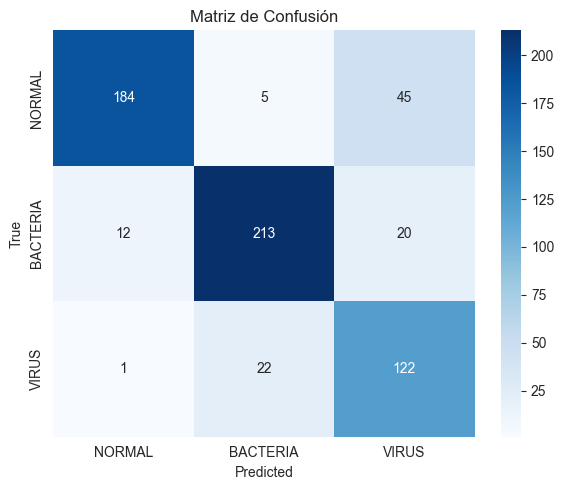

accuracy_BACTERIA,▁
accuracy_NORMAL,▁
accuracy_VIRUS,▁
test_accuracy,▁
train_acc,▁▁▁▁▁▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇███████████████
train_loss,█▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▂▄▆▇▇▇▇▇▇▇▇▇███████████████████████
val_loss,▇██▇▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
accuracy_BACTERIA,86.93878
accuracy_NORMAL,78.63248
accuracy_VIRUS,84.13793


In [10]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.tight_layout()
wandb.log({"matriz_confusion": wandb.Image(plt)})
plt.show()
wandb.finish()